# 1.4.2 A model for the Lake Huron Data - page 18

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import acf
import statsmodels.api as sm
import seaborn as sns

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16, 9]

## Load the dataset

In [ ]:
file = 'https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/datasets/LakeHuron.csv'
df = pd.read_csv(file, 
                 parse_dates=True)
lake = df[['time','value']]

In [ ]:
lake.head()

,time,value
0,1875,580.38
1,1876,581.86
2,1877,580.97
3,1878,580.80
4,1879,579.79


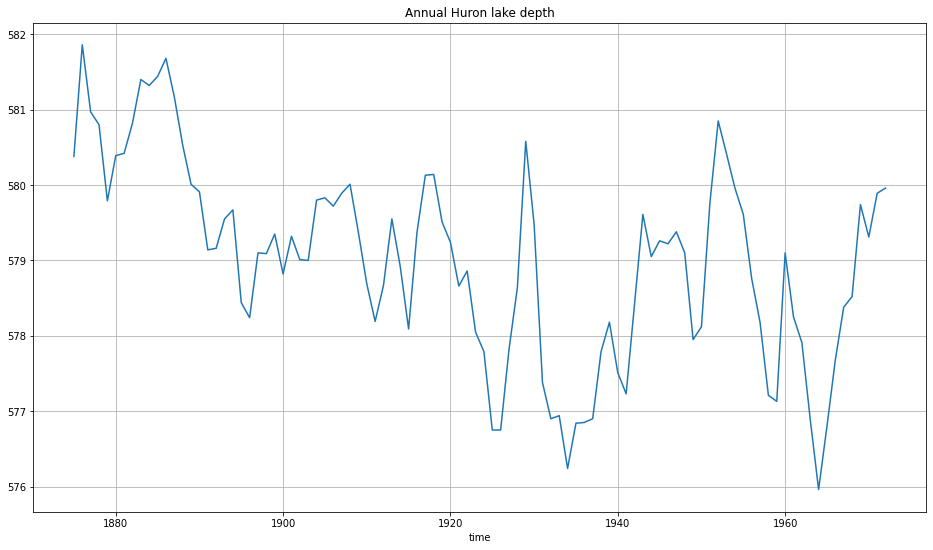

In [ ]:
lake.plot('time', 'value', title='Annual Huron lake depth', legend=False)
plt.grid()
plt.show()

## Analyze the dataset

In [ ]:
# The shape of the dataset
print(lake.shape)
# The info of the dataset
print(lake.info())
# The description of the dataset
display(lake.describe())

(98, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    98 non-null     int64  
 1   value   98 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.7 KB
None


,time,value
count,98.000000,98.000000
mean,1923.500000,579.004082
std,28.434134,1.318299
min,1875.000000,575.960000
25%,1899.250000,578.135000
50%,1923.500000,579.120000
75%,1947.750000,579.875000
max,1972.000000,581.860000


Huron Lake dataset contains 98 observations - the annual lake depth from 1875 to 1972.

## Fit Linear Regression model

In [ ]:
from statsmodels.formula.api import ols

# fit simple linear regression model
linear_model = ols('value ~ time', data=lake).fit()
  
# display model summary
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     35.95
Date:                Sun, 04 Dec 2022   Prob (F-statistic):           3.55e-08
Time:                        03:07:43   Log-Likelihood:                -150.05
No. Observations:                  98   AIC:                             304.1
Df Residuals:                      96   BIC:                             309.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    625.5549      7.764     80.568      0.0

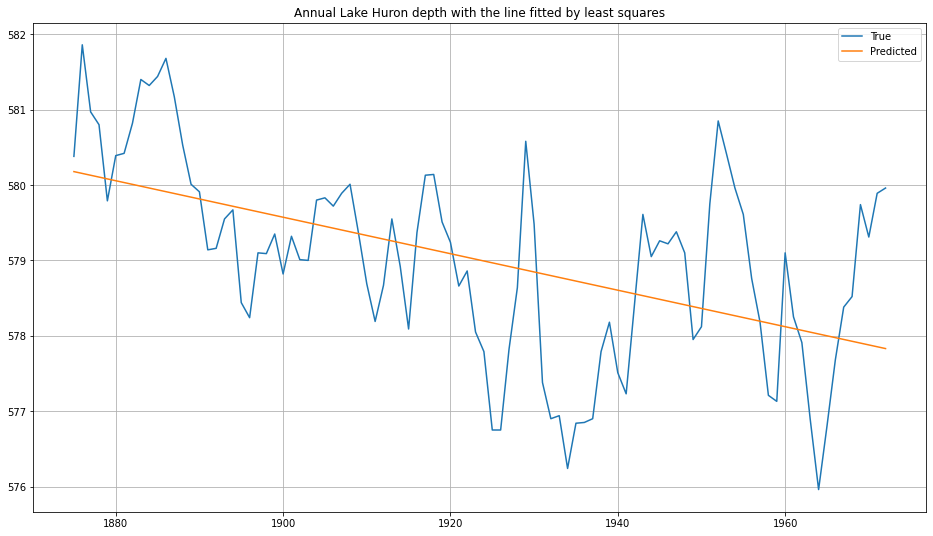

In [ ]:
# Plot the line fitted by least squares
plt.plot(lake['time'], lake['value'], label='True')
plt.plot(lake['time'], linear_model.fittedvalues, label='Predicted')
plt.title('Annual Lake Huron depth with the line fitted by least squares')
plt.legend(loc='best')
plt.grid()
plt.show()

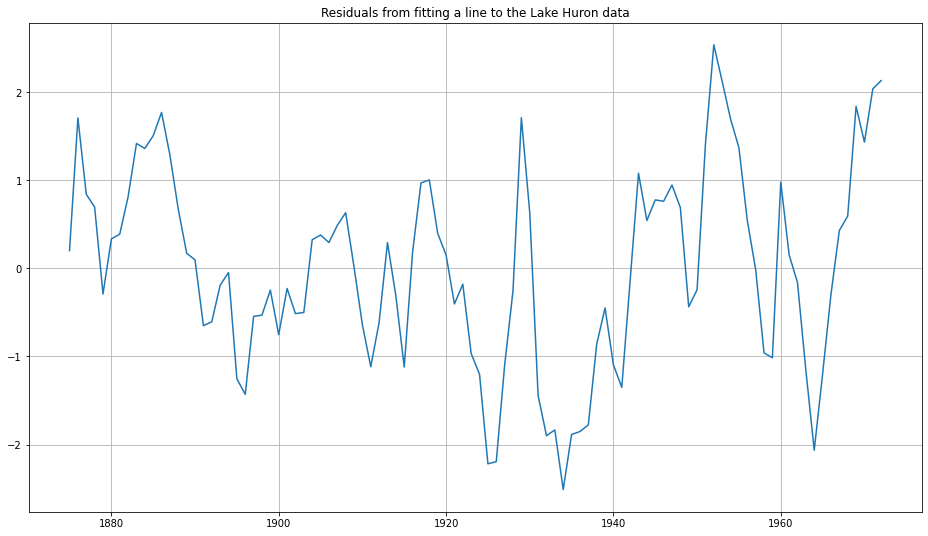

In [ ]:
# Plot residuals from fitting a line to the Lake Huron data
plt.plot(lake['time'], linear_model.resid)
plt.grid()
plt.title('Residuals from fitting a line to the Lake Huron data')
plt.show()

## Autocorrelation Function

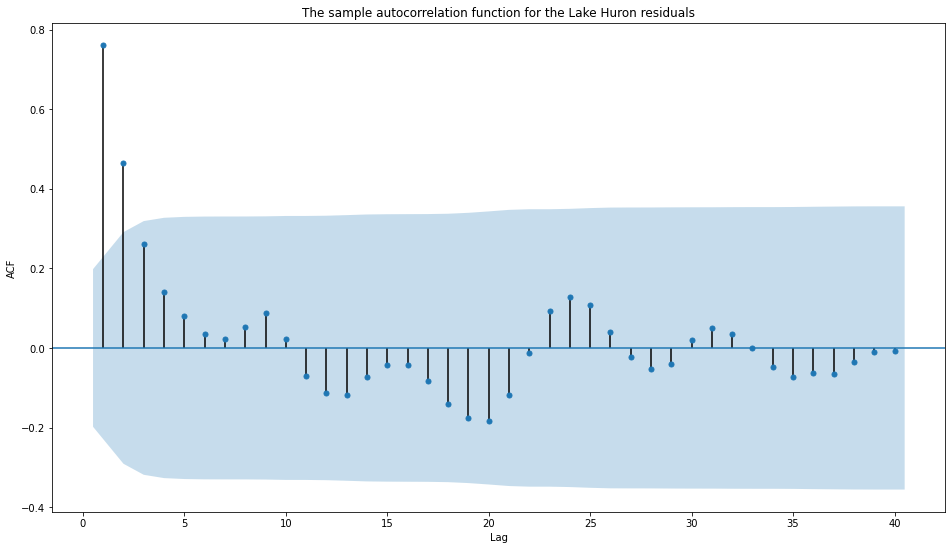

In [ ]:
residuals = linear_model.resid
plot_acf(residuals, zero=False, lags=40)
plt.title('The sample autocorrelation function for the Lake Huron residuals')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

The roughly geometric decay of the first few sample autocorrelations suggests that an AR(1) series.

### AR(1) series for these residuals

In [ ]:
y = residuals[1:].tolist()
x = residuals[:-1].tolist()
# First-Order AutoRegression or AR(1) Process
AR_1 = sm.OLS(y, x).fit()
print(AR_1.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.603
Model:                            OLS   Adj. R-squared (uncentered):              0.598
Method:                 Least Squares   F-statistic:                              145.5
Date:                Sun, 04 Dec 2022   Prob (F-statistic):                    6.09e-21
Time:                        03:07:59   Log-Likelihood:                         -104.25
No. Observations:                  97   AIC:                                      210.5
Df Residuals:                      96   BIC:                                      213.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Fit a straight line of the form $y_t = a y_{t-1}$, we get the model $Y_t = 0.791Y_{t-1} + Z_t$ where $Z_t$ is iid noise.

In [ ]:
# Variance
def variance(series, slope):
    results = []
    for i in range(1, len(series)):
        result = (series[i] - slope * series[i-1])**2
        results.append(result)
    
    return np.sum(results)/(len(series) - 1)

print('Variance: ', round(variance(residuals, AR_1.params), 3))

Variance:  0.502


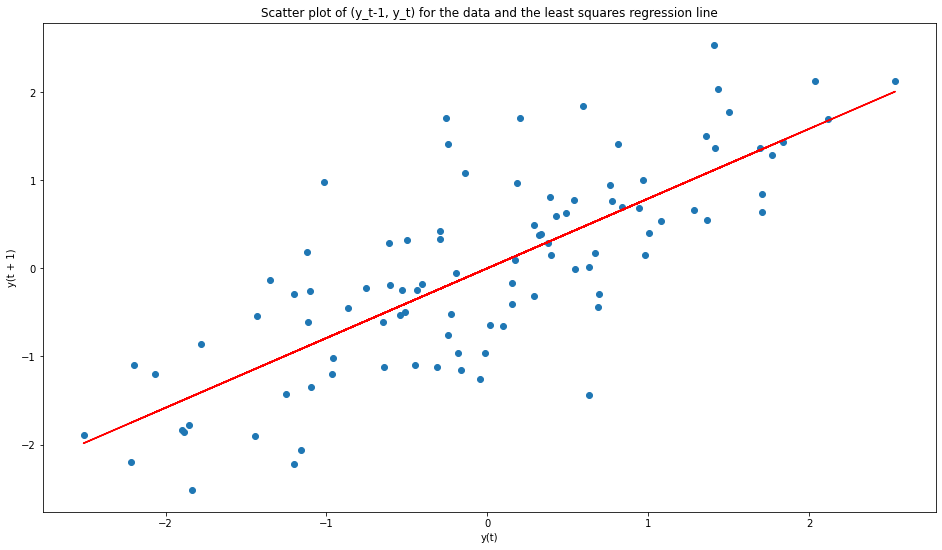

In [ ]:
# lagplot
pd.plotting.lag_plot(residuals, lag=1)
plt.plot(residuals[:-1], AR_1.fittedvalues, 'r')
plt.title('Scatter plot of (y_t-1, y_t) for the data and the least squares regression line')
plt.show()

## Testing the Estimated Noise Sequence

#### a) The sample autocorrelation functions

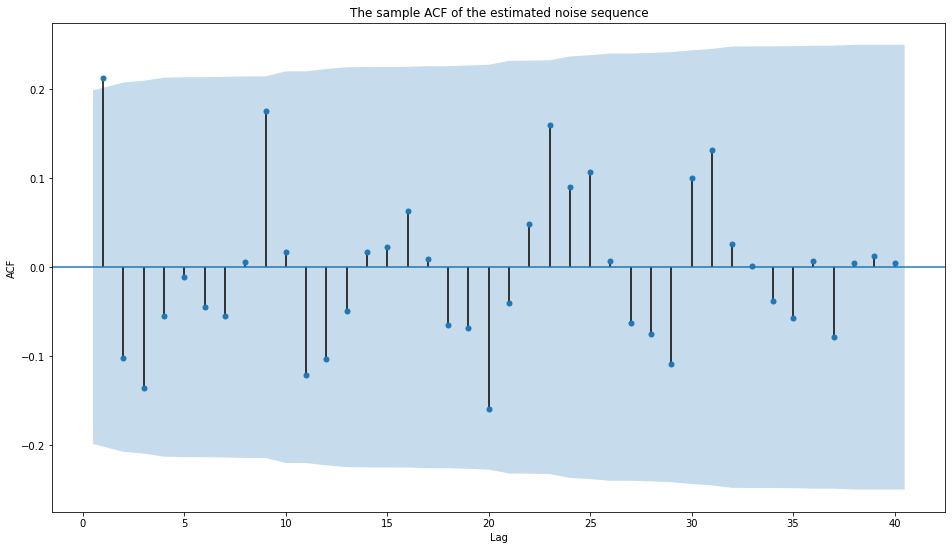

In [ ]:
plot_acf(AR_1.resid, zero=False, lags=40)
plt.title('The sample ACF of the estimated noise sequence')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

In [ ]:
rho = acf(AR_1.resid,nlags = 40,fft = False)
rho[1]

0.2127791524113755

At lag 1, the sample ACF of the estimated noise sequence is outside the bounds, $\hat \rho(1) = 0.212$, but it is inside the bounds for all other lags up to 40.

##### **Durbin-Watson test**
- $H_0$: there is no correlation among the residuals
- $H_A$: The residuals are autocorrelated 

The test statistic is approximately equal to 2*(1-r) where r is the sample autocorrelation of the residuals. Thus, the test statistic will always be between 0 and 4 with the following interpretation:
   - A test statistic of 2 indicates no serial correlation.
   - The closer the test statistics is to 0, the more evidence of positive serial correlation.
   - The closer the test statistics is to 4, the more evidence of negative serial correlation.
   
If test statistic values between the range of 1.5 and 2.5 are considered normal. However, values outside of this range could indicate that autocorrelation is a problem.

In [ ]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(AR_1.resid)

1.5203748746411585

Since this is within the range of 1.5 and 2.5, we would consider autocorrelation not to be problematic in this regression model.

#### b) The portmanteau test

The Ljung-Box test is a statistical test that checks if autocorrelation exists in a time series.
- $H_0$: The residuals are independently distributed.
- $H_A$: The residuals are not independently distributed

Ideally, we would like to fail to reject the null hypothesis.

In [ ]:
sm.stats.acorr_ljungbox(AR_1.resid, lags=[40], return_df=True)

,lb_stat,lb_pvalue
40,35.012036,0.694019


p_value = 0.69 > 0.05. Thus, we do not reject the null hypothesis of the test and conclude that the residuals are independent.

#### c) Checking for normality

The Shapiro-Wilk test is a test of normality. It is used to determine whether or not a sample comes from a normal distribution.

If the p-value is below a certain significance level, then we have sufficient evidence to say that the sample data does not come from a normal distribution.

In [ ]:
import scipy
shapiro_test = scipy.stats.shapiro(AR_1.resid)
shapiro_test

ShapiroResult(statistic=0.9877774715423584, pvalue=0.5143942832946777)

Since the p-value = 0.51 is not less than .05, we fail to reject the null hypothesis. We do not have sufficient evidence to say that the data does not come from a normal distribution.

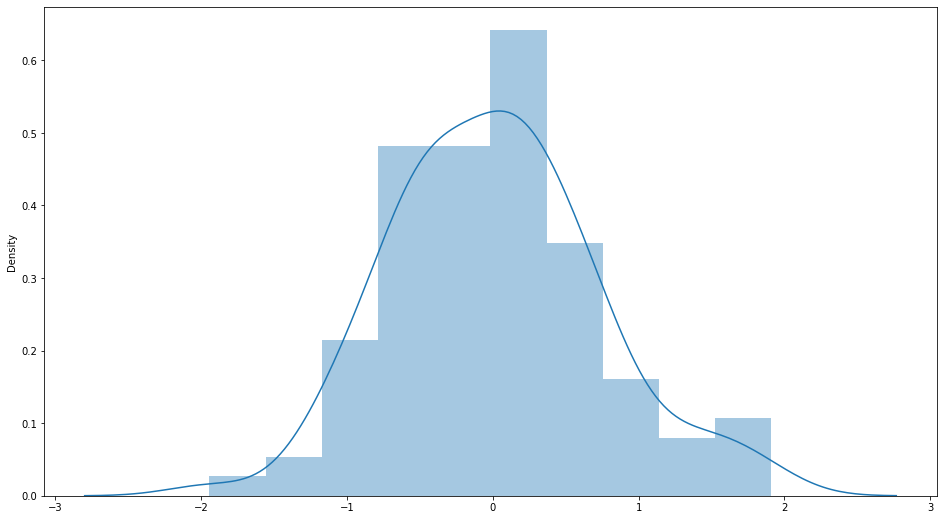

In [ ]:
sns.distplot(AR_1.resid, bins=10)
plt.show()

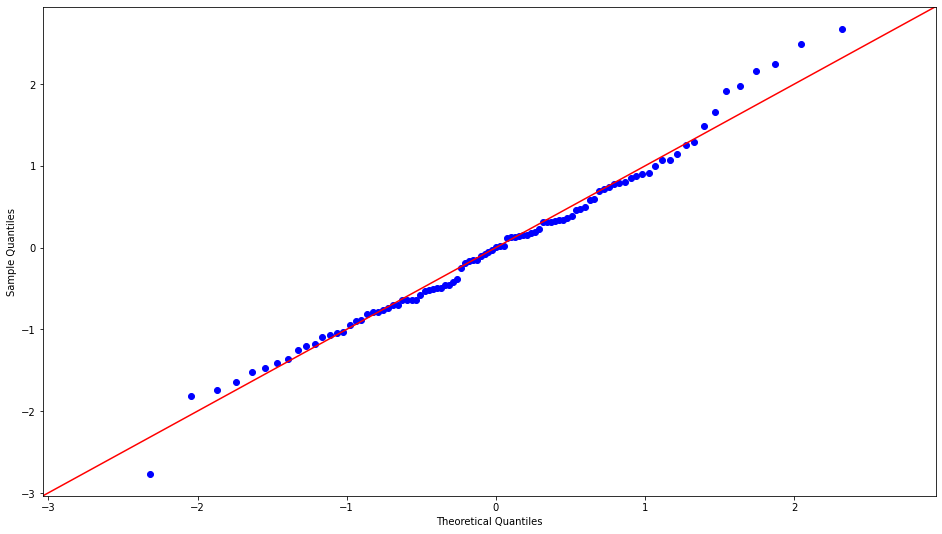

In [ ]:
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
qqplot(AR_1.resid,norm,fit=True,line="45")
plt.show()

## Using autoregression model

### AR(1)

In [ ]:
from statsmodels.tsa.ar_model import AutoReg
mod_1 = AutoReg(residuals, 1, old_names=False)
res_1 = mod_1.fit()
print(res_1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   98
Model:                     AutoReg(1)   Log Likelihood                -104.231
Method:               Conditional MLE   S.D. of innovations              0.709
Date:                Sun, 04 Dec 2022   AIC                             -0.627
Time:                        03:08:29   BIC                             -0.547
Sample:                             1   HQIC                            -0.595
                                   98                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0153      0.072      0.212      0.832      -0.126       0.156
y.L1           0.7911      0.065     12.130      0.000       0.663       0.919
                                    Roots           

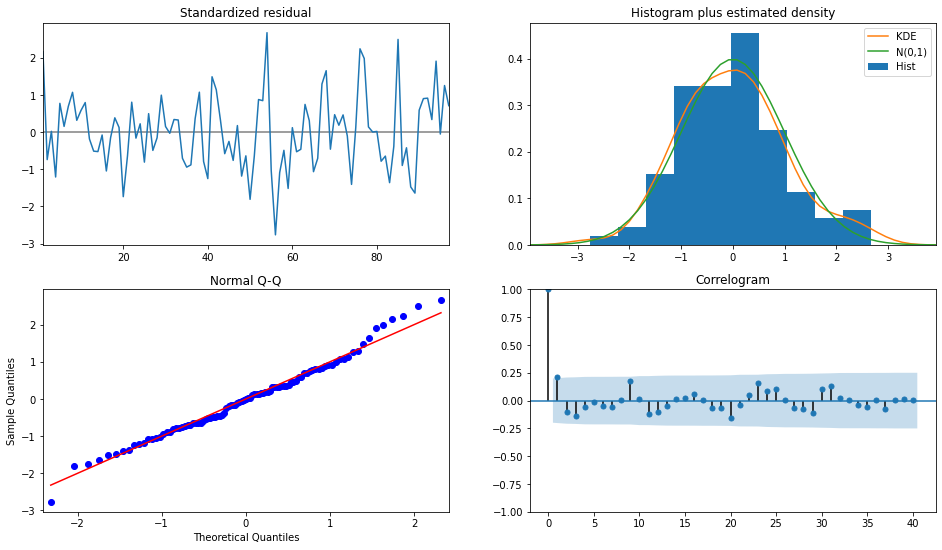

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_1.plot_diagnostics(fig=fig, lags=40)

### AR(2)

In [ ]:
mod_2 = AutoReg(residuals, 2, old_names=False)
res_2 = mod_2.fit()
print(res_2.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                   98
Model:                     AutoReg(2)   Log Likelihood                 -97.196
Method:               Conditional MLE   S.D. of innovations              0.666
Date:                Sun, 04 Dec 2022   AIC                             -0.730
Time:                        03:08:38   BIC                             -0.623
Sample:                             2   HQIC                            -0.686
                                   98                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0079      0.068     -0.115      0.908      -0.141       0.125
y.L1           1.0021      0.096     10.473      0.000       0.815       1.190
y.L2          -0.2838      0.097     -2.912      0.0

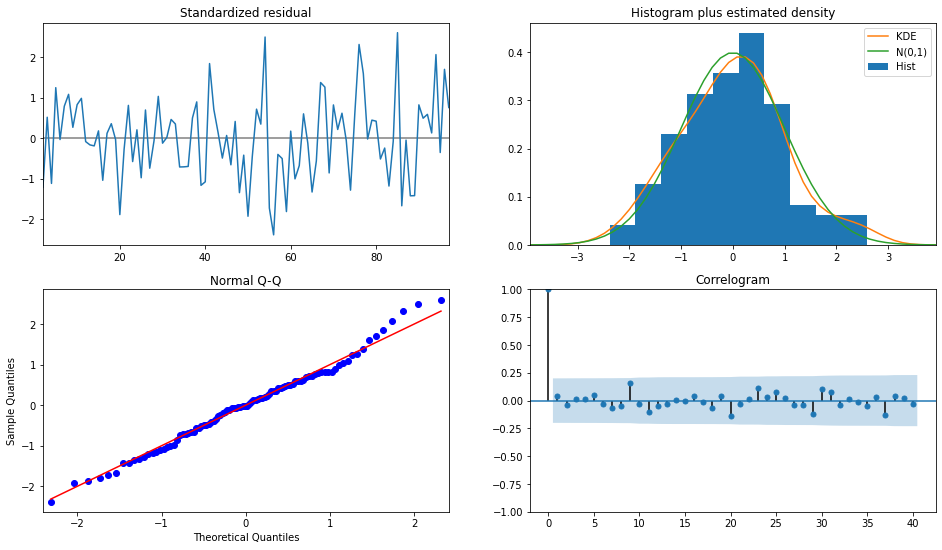

In [ ]:
fig = plt.figure(figsize=(16, 9))
fig = res_2.plot_diagnostics(fig=fig, lags=40)

In [ ]:
np.var(res_2.resid)

0.443541017009706

In [ ]:
variance_difference = (np.var(res_2.resid) - np.var(res_1.resid))*100
variance_difference

-5.864372278565616

- The estimate of noise variance for the AR(2) model is 5.86% smaller than that for the AR(1) one.
- All lags up to 40 fall well within the bounds.